In [1]:
import numpy as np
from scipy.optimize import root_scalar, minimize, minimize_scalar
import matplotlib.pyplot as plt
from matplotlib.patches import Arc
from matplotlib.animation import FuncAnimation
import io
import tqdm
import math
TOLERANCE = 0.05

In [2]:
def get_original_string_length(l, arc_length):
    node_length = []
    for i in range(len(l) - 1):
        node_length.append(np.sqrt(arc_length**2 + (l[i+1] - l[i])**2))
    return node_length

def find_radian(x1, y1, theta1, arc_length, l1, l2, target_string_length):
    # print("x1: ", x1, "y1: ", y1, "theta1: ", theta1, "arc_length: ", arc_length, "l1: ", l1, "l2: ", l2, "target_string_length: ", target_string_length)
    def f(r):
        err = calculate_L(r, x1, y1, theta1, arc_length, l1, l2) - target_string_length
        # print(f"r: {r}, err: {err}")
        return err
    
    # 这里必须设置取值范围，否则可能会出现异常解。限定在+-1.8pi之间就能满足大部分需求了
    # result = minimize_scalar(f, bounds=(-np.pi*1.8, np.pi*1.8), method='bounded').x # 这两种都是有时好用有时不好用的
    result = root_scalar(f, bracket=(-np.pi*1.8, np.pi*1.8), method='newton', x0=0.001, x1=-0.001).root # 难顶
    return result


def optimize_radians_get_string_length(l, target_length, x1, y1, theta1, arc_length, initial_guess=None):
    n = len(l) - 1  # 级联数量

    # 检查target_length大于original连线
    node_length = get_original_string_length(l, arc_length)
    assert sum(node_length) > target_length, "target_length:"+str(target_length)+"大于original连线: " + str(sum(node_length))

    def objective(string_lengths):
        radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, string_lengths, l)
        radians = np.array(radians)
        # radians就是potential energy的表示，要让总的potential energy最小
        return np.sum(np.power(radians, 2))

    def constraint(string_lengths):
        return sum(string_lengths) - target_length

    # 初始值按照original连线长度分配是最合适的，实测平均线长更容易陷入局部最小值
    # 新加入可以自定义初始值，可以实现让上一个最优解作为下一个的初始值
    if initial_guess is None:
        initial_guess = node_length

    # 约束条件
    cons = [{'type': 'eq', 'fun': constraint}]

    for i, l_i in enumerate(l):
        if l_i == 0:
            cons.append({'type': 'eq', 'fun': lambda string_lengths: string_lengths[i-1] - arc_length})

    # 优化
    res = minimize(objective, initial_guess, method='trust-constr', constraints=cons, options={
        # 'xtol': 1e-12,
        # 'gtol': 1e-12,
        'maxiter': 10000,
        'initial_tr_radius': 0.1
    })
    # trust-constr是目前测试最合适的，SLSQP很容易解出异常值，其他的会失败
    
    if res.success:
        return res.x  # 返回最优的string_length分配
    else:
        print(res)
        raise ValueError("优化失败")



In [3]:
import numpy as np

def calculate_L(radian, x1, y1, theta1, arc_length, l1, l2):
    # Calculate the unit vector of theta
    v = np.array([np.cos(theta1), np.sin(theta1)])
    if -0.001 < radian < 0.001:
        # Calculate as a straight line
        # Calculate the vector of arc_length, direction is perpendicular to theta
        v_arc = np.array([-np.sin(theta1), np.cos(theta1)])
        # Calculate coordinates of S1 and S2
        S1_x = x1 + l1 * v[0]
        S1_y = y1 + l1 * v[1]
        S2_x = x1 + l2 * v[0] + arc_length * v_arc[0]
        S2_y = y1 + l2 * v[1] + arc_length * v_arc[1]
        return np.linalg.norm([S2_x - S1_x, S2_y - S1_y])
    
    # Calculate radius
    radius = arc_length / radian
    
    # Calculate the center coordinates; x1, y1 is the start point, theta1 is the start angle
    x0 = x1 - radius * np.cos(theta1)
    y0 = y1 - radius * np.sin(theta1)

    # Calculate the coordinates of the endpoint of the arc
    # x2 = x1 + arc_length * np.cos(theta1 + radian + np.pi / 2)
    # y2 = y1 + arc_length * np.sin(theta1 + radian + np.pi / 2)
    x2 = x0 + radius * np.cos(theta1 + radian)
    y2 = y0 + radius * np.sin(theta1 + radian)


    # # # 计算圆弧两端点的坐标
    x22 = x1 + arc_length * np.cos(theta1 + radian + np.pi / 2)
    y22 = y1 + arc_length * np.sin(theta1 + radian + np.pi / 2)

    ratio = 0.5
    x2 = (1-ratio)*x22 + ratio*x2 
    y2 = (1-ratio)*y22 + ratio*y2 


    
    # Calculate unit vectors from center to endpoints
    v1 = np.array([x1 - x0, y1 - y0])
    v1 = v1 / np.linalg.norm(v1)
    v2 = np.array([x2 - x0, y2 - y0])
    v2 = v2 / np.linalg.norm(v2)
    
    # Calculate the coordinates of points S1 and S2
    if radian < 0:
        l1 = -l1
        l2 = -l2
    S1_x = x1 + l1 * v1[0]
    S1_y = y1 + l1 * v1[1]
    S2_x = x2 + l2 * v2[0]
    S2_y = y2 + l2 * v2[1]
    
    # Calculate the actual distance L
    return np.linalg.norm([S2_x - S1_x, S2_y - S1_y])


In [4]:
def calculate_geometry(rod_length, x1, y1, theta1, arc_length, radians, l):
    result = {
        "rods": [],
        "arcs": [],
        "strings": []
    }
    
    x, y, theta = x1, y1, theta1
    
    # 计算第一根rod
    rod_start = (x - rod_length/2 * np.cos(theta), y - rod_length/2 * np.sin(theta))
    rod_end = (x + rod_length/2 * np.cos(theta), y + rod_length/2 * np.sin(theta))
    result["rods"].append([rod_start, rod_end])
    print(radians)
    for i, radian in enumerate(radians):
        if radian > -0.001 and radian < 0.001:
            result["arcs"].append({
                "center": (np.inf, np.inf),
                "radius": float('inf'),
                "start_angle": theta,
                "end_angle": theta,
                "line": [(x, y), (x + arc_length * np.cos(theta+np.pi/2), y + arc_length * np.sin(theta+np.pi/2))]
            })
            x_next = x + arc_length * np.cos(theta + np.pi/2)
            y_next = y + arc_length * np.sin(theta + np.pi/2)
            rod_start = (x_next - rod_length/2 * np.cos(theta), 
                         y_next - rod_length/2 * np.sin(theta))
            rod_end = (x_next + rod_length/2 * np.cos(theta),
                          y_next + rod_length/2 * np.sin(theta))
            result["rods"].append([rod_start, rod_end])
            if i == 0:  # 第一个string
                string_start = (x + l[0] * np.cos(theta), y + l[0] * np.sin(theta))
            else:
                string_start = result["strings"][-1][1]  # 上一个string的终点
            string_end = (x_next + l[i+1] * np.cos(theta), y_next + l[i+1] * np.sin(theta))
            result["strings"].append([string_start, string_end])
            x, y = x_next, y_next
            continue
        # 计算半径
        radius = arc_length / radian
        
        # 计算圆弧
        circle_center_x = x - radius * np.sin(theta + np.pi/2)
        circle_center_y = y + radius * np.cos(theta + np.pi/2)
        arc_start_angle = theta
        arc_end_angle = arc_start_angle + radian
        
        result["arcs"].append({
            "center": (circle_center_x, circle_center_y),
            "radius": radius,
            "start_angle": arc_start_angle if radian >= 0 else arc_end_angle,
            "end_angle": arc_end_angle if radian >= 0 else arc_start_angle
        })
        
        # 计算圆弧终点
        x_next = circle_center_x + radius * np.cos(arc_end_angle)
        y_next = circle_center_y + radius * np.sin(arc_end_angle)
        
        # 计算R向量
        R_x = x_next - circle_center_x
        R_y = y_next - circle_center_y
        if radian < 0:
            R_x, R_y = -R_x, -R_y
        R_unit = np.array([R_x, R_y]) / np.linalg.norm([R_x, R_y])
        theta_next = np.arctan2(R_y, R_x)
        
        # 计算下一根rod
        rod_start = (x_next - rod_length/2 * np.cos(theta_next), 
                     y_next - rod_length/2 * np.sin(theta_next))
        rod_end = (x_next + rod_length/2 * np.cos(theta_next), 
                   y_next + rod_length/2 * np.sin(theta_next))
        result["rods"].append([rod_start, rod_end])
        
        # 计算string
        if i == 0:  # 第一个string
            string_start = (x + l[0] * np.cos(theta), y + l[0] * np.sin(theta))
        else:
            string_start = result["strings"][-1][1]  # 上一个string的终点
        
        string_end = (x_next + l[i+1] * R_unit[0], y_next + l[i+1] * R_unit[1])
        result["strings"].append([string_start, string_end])
        
        # 更新下一次迭代的起始点
        x, y, theta = x_next, y_next, theta_next
    
    return result

def calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, string_lengths, l):
    radians = []
    x, y, theta = x1, y1, theta1
    for i, L in enumerate(string_lengths):
        radian = find_radian(x, y, theta, arc_length, l[i], l[i+1], L)
        x, y, theta = calculate_next_point(x, y, theta, arc_length, radian)
        radians.append(radian)
    return radians

# 辅助函数：计算下一个点的位置和角度
def calculate_next_point(x, y, theta, arc_length, radian):
    if radian > -0.001 and radian < 0.001:
        x_next = x + arc_length * np.cos(theta + np.pi/2)
        y_next = y + arc_length * np.sin(theta + np.pi/2)
        return x_next, y_next, theta + radian
    # 计算半径
    radius = arc_length / radian
    
    # 计算圆弧
    circle_center_x = x - radius * np.sin(theta + np.pi/2)
    circle_center_y = y + radius * np.cos(theta + np.pi/2)
    arc_end_angle = theta + radian
    
    # 计算圆弧终点
    x_next = circle_center_x + radius * np.cos(arc_end_angle)
    y_next = circle_center_y + radius * np.sin(arc_end_angle)
    return x_next, y_next, arc_end_angle



In [82]:
def plot_geometry(geometry_result,name="test.png"):
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # 绘制rods（黑色，较粗）
    for rod in geometry_result['rods']:
        x_values = [rod[0][0], rod[1][0]]
        y_values = [rod[0][1], rod[1][1]]
        ax.plot(x_values, y_values, color='black', linewidth=2)
    
    # 绘制arcs（红色，较粗）
    for arc in geometry_result['arcs']:
        center = arc['center']
        radius = arc['radius']
        start_angle = arc['start_angle']
        end_angle = arc['end_angle']
        if radius != float('inf'):
            arc_patch = Arc(center, 2*radius, 2*radius,
                            angle=0, theta1=np.degrees(start_angle),
                            theta2=np.degrees(end_angle),
                            color='red', linewidth=2)
            ax.add_patch(arc_patch)
        else: # 画直线，用line参数
            x_values = [arc['line'][0][0], arc['line'][1][0]]
            y_values = [arc['line'][0][1], arc['line'][1][1]]
            ax.plot(x_values, y_values, color='red', linewidth=2)
    
    # 绘制strings（蓝色，较细）
    for string in geometry_result['strings']:
        x_values = [string[0][0], string[1][0]]
        y_values = [string[0][1], string[1][1]]
        ax.plot(x_values, y_values, color='blue', linewidth=1)
    
    # 设置坐标轴等比例
    ax.set_aspect('equal', 'box')

    
    # Set the x and y axis limits as specified (-10, 100 for x-axis, -20, 200 for y-axis)
    ax.set_xlim([-10, 200])
    ax.set_ylim([-25, 110])
    


        # Add labels to the axes with larger font sizes
    plt.xlabel('X (mm)', fontsize=14)  # Set font size to 14 (adjust as needed)
    plt.ylabel('Y (mm)', fontsize=14)  # Set font size to 14 (adjust as needed)
    
    # Make the tick labels (numbers on axes) larger
    ax.tick_params(axis='both', which='major', labelsize=14)  # Set font size to 12 for the numbers


    
    
    # 显示网格
    plt.grid(True)
    
    # 自动调整坐标轴范围
    plt.savefig(name)
    
    # 显示图形
    plt.show()

# # 使用示例
# plot_geometry(result)

def create_geometry_gif(geometry_results, x_range, y_range, interval=200, filename='geometry_animation.gif'):
    if not geometry_results:
        print("Error: geometry_results is empty")
        return

    fig, ax = plt.subplots(figsize=(10, 10))

    def update(frame):
        ax.clear()
        if frame >= len(geometry_results):
            print(f"Error: frame {frame} is out of range. Total frames: {len(geometry_results)}")
            return
        
        geometry_result = geometry_results[frame]
        
        if not isinstance(geometry_result, dict):
            print(f"Error: Invalid geometry_result at frame {frame}. Expected dict, got {type(geometry_result)}")
            return

        # 绘制rods（黑色，较粗）
        if 'rods' in geometry_result:
            for rod in geometry_result['rods']:
                if len(rod) != 2 or not all(len(point) == 2 for point in rod):
                    print(f"Error: Invalid rod data at frame {frame}: {rod}")
                    continue
                x_values = [rod[0][0], rod[1][0]]
                y_values = [rod[0][1], rod[1][1]]
                ax.plot(x_values, y_values, color='black', linewidth=2)
        
        # 绘制arcs（红色，较粗）
        if 'arcs' in geometry_result:
            for arc in geometry_result['arcs']:
                if not all(key in arc for key in ['center', 'radius', 'start_angle', 'end_angle']):
                    print(f"Error: Invalid arc data at frame {frame}: {arc}")
                    continue
                center = arc['center']
                radius = arc['radius']
                start_angle = arc['start_angle']
                end_angle = arc['end_angle']
                if radius != float('inf'):
                    arc_patch = Arc(center, 2*radius, 2*radius,
                                    angle=0, theta1=np.degrees(start_angle),
                                    theta2=np.degrees(end_angle),
                                    color='red', linewidth=2)
                    ax.add_patch(arc_patch)
                else: # 画直线，用line参数
                    if 'line' not in arc or len(arc['line']) != 2:
                        print(f"Error: Invalid line data for infinite radius arc at frame {frame}: {arc}")
                        continue
                    x_values = [arc['line'][0][0], arc['line'][1][0]]
                    y_values = [arc['line'][0][1], arc['line'][1][1]]
                    ax.plot(x_values, y_values, color='red', linewidth=2)
        
        # 绘制strings（蓝色，较细）
        if 'strings' in geometry_result:
            for string in geometry_result['strings']:
                if len(string) != 2 or not all(len(point) == 2 for point in string):
                    print(f"Error: Invalid string data at frame {frame}: {string}")
                    continue
                x_values = [string[0][0], string[1][0]]
                y_values = [string[0][1], string[1][1]]
                ax.plot(x_values, y_values, color='blue', linewidth=1)
        
        # 设置坐标轴等比例
        ax.set_aspect('equal', 'box')
        
        # 添加标题和标签
        ax.set_title(f'Geometry Visualization (Frame {frame + 1}/{len(geometry_results)})')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        
        # 显示网格
        ax.grid(True)
        
        # 设置坐标轴范围
        ax.set_xlim(x_range)
        ax.set_ylim(y_range)

    # 创建动画
    anim = FuncAnimation(fig, update, frames=len(geometry_results), interval=interval, blit=False)

    # 保存为GIF
    try:
        anim.save(filename, writer='pillow', fps=1000/interval)
    except Exception as e:
        print(f"Error saving GIF: {e}")
    
    plt.close(fig)

In [83]:
# new functions
    
def helper(x1, y1, theta1, arc_length, radian, rod_length):
    possible_solutions = []
    if radian == 0:
        # possible_solutions = [(-0.5, -0.5, arc_length),(0.5, 0.5, arc_length)]
        possible_solutions = [(-0.5, -0.5, arc_length)]
        return possible_solutions
    keys = list(wiring_mapping.keys())  # Ensure two distinct keys for pairing
    for i in range(len(keys)):
        for j in range(len(keys)):  # Ensure unique pairs of l1, l2
            l1 = wiring_mapping[keys[i]]
            l2 = wiring_mapping[keys[j]]
            
            l = calculate_L(radian, x1, y1, theta1, arc_length, l1, l2)
            max_value = np.linalg.norm([arc_length, l1-l2]) 
            if l < max_value:
                # test_radian = find_radian(x1, y1, theta1, arc_length, l1, l2, l)
                # if abs(test_radian - radian) < TOLERANCE: # 10 degrees
                possible_solutions.append((l1, l2, l))   
    return possible_solutions

    
def find_all_threading_paths(all_threading_segments):
    # Use a backtracking method to generate all possible valid paths
    def backtrack(current_path, segment_idx, total_length):
        if segment_idx == len(all_threading_segments):
            # Append the flattened valid path and its total length
            valid_paths.append(([t[0] for t in current_path] + [current_path[-1][1]], total_length))
            return
        
        current_segment = all_threading_segments[segment_idx]
        # For each solution in the current segment, check if it can continue the current path
        for solution in current_segment:
            if len(current_path) == 0 or current_path[-1][1] == solution[0]:  # Check if end matches start (l1, l2)
                backtrack(current_path + [solution], segment_idx + 1, total_length + solution[2])  # Add l to total length

    valid_paths = []
    backtrack([], 0, 0)  # Start backtracking from the first segment, with initial total_length = 0
    return valid_paths


def find_threadings(x1, y1, theta1, arc_length, radians,rod_length):
    all_threading_segments = []
    for (i, radian) in enumerate(radians):
        print("The current position: x1 =", x1, "y1 =", y1, "theta1 =", theta1)
        possible_solutions = helper(x1, y1, theta1, arc_length, radian, rod_length) 
        if len(possible_solutions) == 0:
            print("NO SOLUTION at radian:", radian)
            return None
        else:
            all_threading_segments.append(possible_solutions)
        
        x1, y1, theta1 = calculate_next_point(x1, y1, theta1, arc_length, radian)
        print("New position after arc_length:", x1, y1, theta1)
    
    # Generate all possible valid threading paths from start to goal
    valid_paths = find_all_threading_paths(all_threading_segments)
    if valid_paths:
        print("All valid threading paths found:")
        print("number of paths: ", len(valid_paths))
        # for path, total_length in valid_paths:
            # print(f"Path: {path}, Total Length: {total_length}")
        return valid_paths
    else:
        print("No valid threading paths found.")
        return None


The current position: x1 = 0 y1 = 0 theta1 = -1.5707963267948966
New position after arc_length: 17.188733853924695 4.605707355072621 -1.0471975511965979
The current position: x1 = 17.188733853924695 y1 = 4.605707355072621 theta1 = -1.0471975511965979
New position after arc_length: 34.37746770784939 9.211414710145242 -1.5707963267948966
The current position: x1 = 34.37746770784939 y1 = 9.211414710145242 theta1 = -1.5707963267948966
New position after arc_length: 51.566201561774086 13.817122065217863 -1.0471975511965979
The current position: x1 = 51.566201561774086 y1 = 13.817122065217863 theta1 = -1.0471975511965979
New position after arc_length: 68.75493541569878 18.422829420290483 -1.5707963267948966
The current position: x1 = 68.75493541569878 y1 = 18.422829420290483 theta1 = -1.5707963267948966
New position after arc_length: 85.94366926962348 23.028536775363104 -1.0471975511965979
The current position: x1 = 85.94366926962348 y1 = 23.028536775363104 theta1 = -1.0471975511965979
New p

Processing Threadings:  20%|████▍                 | 1/5 [00:13<00:55, 13.88s/it]


original angles:  [30, -30, 30, -30, 30, -30, 30, -30, 30, -30, 30]
optimal angles:  [ 30. -30.  30. -30.  30. -30.  30. -30.  30. -30.  30.]
min_distance:  1.1575843833725335e-07
string length:  224.46304775623213
threading pattern: [-6.5, 6.5, -6.5, 6.5, -6.5, 6.5, -6.5, 6.5, -6.5, 6.5, -6.5, 6.5]
[0.5235988177313128, -0.5235987389205538, 0.5235987900191996, -0.5235988261725179, 0.5235987123440555, -0.5235988038418811, 0.5235987637976582, -0.5235987380300547, 0.5235987533472894, -0.5235987909664247, 0.5235987964103185]


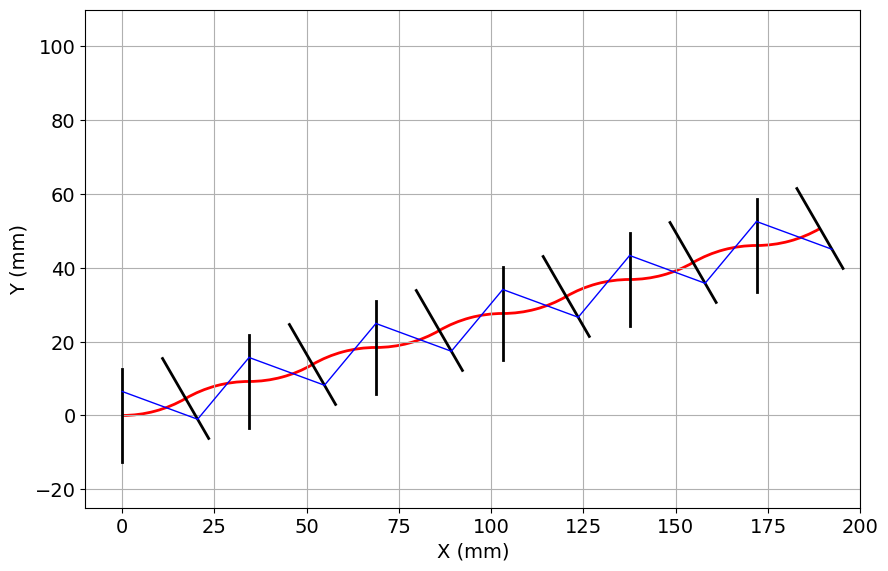

In [84]:
from tqdm import tqdm
import numpy as np
import random

def calculate_distance(arr1, arr2):
    # Use np.linalg.norm to calculate the L2 distance between two arrays
    return np.linalg.norm(np.array(arr1) - np.array(arr2))


wiring_mapping = {
    "L0": -0.5,
    # "L1": -3,
    "L2": -6.5,
    # "L3": -10,
    # "R0": 0.5,
    # "R1": 3,
    "R2": 6.5,
    # "R3": 10
    }
if __name__ == "__main__":

    # The tests for paper
    arc_length = 18  # arc的长度
    rod_length = 25  # rod的长度
    x1, y1 = 0, 0  # 起始点
    theta1 = -np.pi/2  # 起始角度
    
    angles = [30, -30, 30, -30, 30, -30, 30, -30, 30, -30, 30] 
    radians = [np.radians(angle) for angle in angles]

    optimal_threading = []
    optimal_length = 0
    optimal_radians = []
    min_distance = 2
    max_iteration = 100
    tolerance = 0.1


    threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
    print(len(threadings))
    print("shuffle it")
    random.shuffle(threadings) 
    
    i = 0
    # Add tqdm for progress tracking in the loop
    for threading in tqdm(threadings[0:max_iteration+1], desc="Processing Threadings"):
        i = i + 1
        cur_threading = threading[0]
        cur_length = threading[1]
        
        optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
        cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
        cur_dis = calculate_distance(cur_radians, radians)
        
        if cur_dis < min_distance:
            min_distance = cur_dis
            optimal_threading = cur_threading
            optimal_length = cur_length
            optimal_radians = cur_radians
        if i > max_iteration or min_distance < tolerance:
            break
    
    # Calculate the geometry
    print("original angles: ",angles)
    print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
    print("min_distance: ",min_distance)
    print("string length: ",optimal_length)
    print("threading pattern:", optimal_threading)
    geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)
    
    # Plot the geometry
    plot_geometry(geometry,'image2.png')


The current position: x1 = 0 y1 = 0 theta1 = -1.5707963267948966
New position after arc_length: 17.188733853924695 4.605707355072621 -1.0471975511965979
The current position: x1 = 17.188733853924695 y1 = 4.605707355072621 theta1 = -1.0471975511965979
New position after arc_length: 34.37746770784939 9.211414710145242 -1.5707963267948966
The current position: x1 = 34.37746770784939 y1 = 9.211414710145242 theta1 = -1.5707963267948966
New position after arc_length: 51.566201561774086 13.817122065217863 -1.0471975511965979
The current position: x1 = 51.566201561774086 y1 = 13.817122065217863 theta1 = -1.0471975511965979
New position after arc_length: 68.75493541569878 18.422829420290483 -1.5707963267948966
The current position: x1 = 68.75493541569878 y1 = 18.422829420290483 theta1 = -1.5707963267948966
New position after arc_length: 85.94366926962348 23.028536775363104 -1.0471975511965979
The current position: x1 = 85.94366926962348 y1 = 23.028536775363104 theta1 = -1.0471975511965979
New p

Processing Threadings:  80%|█████████████████▌    | 4/5 [00:42<00:10, 10.53s/it]


original angles:  [30, -30, 30, -30, 30, -30, 30, -30, 30, -30, 30]
optimal angles:  [ 30. -30.  30. -30.  30. -30.  30. -30.  30. -30.  30.]
min_distance:  9.356804055257255e-08
string length:  269.7216333200525
threading pattern: [-10, 10, -10, 10, -10, 10, -10, 10, -10, 10, -10, 10]
[0.5235987794511195, -0.5235988134293754, 0.5235988132889478, -0.5235987689148967, 0.5235987549132978, -0.523598738115647, 0.5235988162026575, -0.5235987315091197, 0.5235987867957314, -0.5235987597001897, 0.5235987692602967]


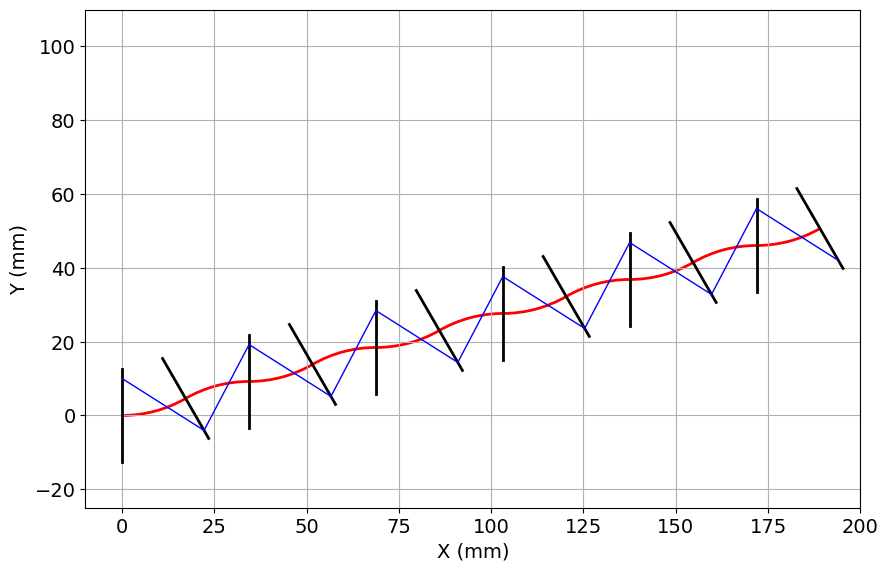

In [85]:
from tqdm import tqdm
import numpy as np
import random

def calculate_distance(arr1, arr2):
    # Use np.linalg.norm to calculate the L2 distance between two arrays
    return np.linalg.norm(np.array(arr1) - np.array(arr2))


wiring_mapping = {
    "L0": -0.5,
    # "L1": -3,
    # "L2": -6.5,
    "L3": -10,
    # "R0": 0.5,
    # "R1": 3,
    # "R2": 6.5,
    "R3": 10
    }
if __name__ == "__main__":

    # The tests for paper
    arc_length = 18  # arc的长度
    rod_length = 25  # rod的长度
    x1, y1 = 0, 0  # 起始点
    theta1 = -np.pi/2  # 起始角度
    
    angles = [30, -30, 30, -30, 30, -30, 30, -30, 30, -30, 30] 
    radians = [np.radians(angle) for angle in angles]

    optimal_threading = []
    optimal_length = 0
    optimal_radians = []
    min_distance = 2
    max_iteration = 100
    tolerance = 0.1


    threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
    print(len(threadings))
    print("shuffle it")
    random.shuffle(threadings) 
    
    i = 0
    # Add tqdm for progress tracking in the loop
    for threading in tqdm(threadings[0:max_iteration+1], desc="Processing Threadings"):
        i = i + 1
        cur_threading = threading[0]
        cur_length = threading[1]
        
        optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
        cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
        cur_dis = calculate_distance(cur_radians, radians)
        
        if cur_dis < min_distance:
            min_distance = cur_dis
            optimal_threading = cur_threading
            optimal_length = cur_length
            optimal_radians = cur_radians
        if i > max_iteration or min_distance < tolerance:
            break
    
    # Calculate the geometry
    print("original angles: ",angles)
    print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
    print("min_distance: ",min_distance)
    print("string length: ",optimal_length)
    print("threading pattern:", optimal_threading)
    geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)
    
    # Plot the geometry
    plot_geometry(geometry,'image1.png')


In [73]:
# from tqdm import tqdm
# import numpy as np
# import random

# def calculate_distance(arr1, arr2):
#     # Use np.linalg.norm to calculate the L2 distance between two arrays
#     return np.linalg.norm(np.array(arr1) - np.array(arr2))

# wiring_mapping = {
#     "L0": -0.5,
#     "L1": -3,
#     "L2": -6.5,
#     "L3": -10,
#     "R0": 0.5,
#     "R1": 3,
#     "R2": 6.5,
#     "R3": 10
# }


# # if __name__ == "__main__":

# # The tests for paper
# arc_length = 18  # arc的长度
# rod_length = 25  # rod的长度
# x1, y1 = 0, 0  # 起始点
# theta1 = -np.pi/2  # 起始角度

# angles = [0,0,0,-30,-10,0,10,30,0,0,0] 
# # angles = [0,0,0,-10,-25,0,10,30,0,0,0] 
# radians = [np.radians(angle) for angle in angles]

# optimal_threading = []
# optimal_length = 0
# optimal_radians = []
# min_distance = 2
# max_iteration = 30
# tolerance = 0.1


# threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
# print(len(threadings))
# print("shuffle it")
# # random.shuffle(threadings) 

# i = 0
# # Add tqdm for progress tracking in the loop
# for threading in tqdm(threadings[0:max_iteration], desc="Processing Threadings"):
#     i = i + 1
#     cur_threading = threading[0]
#     cur_length = threading[1]
    
#     optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
#     cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
#     cur_dis = calculate_distance(cur_radians, radians)
    
#     if cur_dis < min_distance:
#         min_distance = cur_dis
#         optimal_threading = cur_threading
#         optimal_length = cur_length
#         optimal_radians = cur_radians
#     if i > max_iteration or min_distance < tolerance:
#         break

# # Calculate the geometry
# print("original angles: ",angles)
# print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
# print("optimal threading:",optimal_threading)
# print("min_distance: ",min_distance)
# print("optimal string length is: ",optimal_length)
# geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)

# # Plot the geometry
# plot_geometry(geometry,"image.png")



In [74]:
# for i in range(1,4):
#     l = optimal_threading
#     target_length = optimal_length - 5*i  # 目标总长度
#     print("---------------------------------------------------------------")
#     optimal_string_length = optimize_radians_get_string_length(l, target_length, x1, y1, theta1, arc_length)
#     print("optimal_string_length: ", optimal_string_length)
#     cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, l)
#     print("cur_radians: ", cur_radians)
#     print("radians is:", radians)
#     cur_dis = calculate_distance(cur_radians, radians)
#     print("cur_dis: ", cur_dis)
#     if cur_dis < min_distance:
#         print("smaller")
#         min_distance = cur_dis
#         optimal_threading = cur_threading
#         optimal_length = cur_length
#         optimal_radians = cur_radians
#         geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, l) 
#         plot_geometry(geometry)


The current position: x1 = 0 y1 = 0 theta1 = -1.5707963267948966
New position after arc_length: 18.0 0.0 -1.5707963267948966
The current position: x1 = 18.0 y1 = 0.0 theta1 = -1.5707963267948966
New position after arc_length: 36.0 0.0 -1.5707963267948966
The current position: x1 = 36.0 y1 = 0.0 theta1 = -1.5707963267948966
New position after arc_length: 54.0 0.0 -1.5707963267948966
The current position: x1 = 54.0 y1 = 0.0 theta1 = -1.5707963267948966
New position after arc_length: 71.90875386081538 1.5668129406974742 -1.3962634015954636
The current position: x1 = 71.90875386081538 y1 = 1.5668129406974742 theta1 = -1.3962634015954636
New position after arc_length: 89.02667591174847 6.964073031481526 -1.1344640137963142
The current position: x1 = 89.02667591174847 y1 = 6.964073031481526 theta1 = -1.1344640137963142
New position after arc_length: 105.34021607840816 14.571201742814115 -1.1344640137963142
The current position: x1 = 105.34021607840816 y1 = 14.571201742814115 theta1 = -1.1344

Processing Threadings: 100%|████████████████████| 25/25 [04:37<00:00, 11.10s/it]


original angles:  [0, 0, 0, 10, 15, 0, 10, 30, 0, 0, 0]
optimal angles:  [ 1.9  1.9  1.9  7.2 18.6  1.9  9.7 27.7  1.9  1.9  1.9]
optimal threading: [-0.5, -0.5, -0.5, -0.5, -6.5, -0.5, -0.5, -10, -0.5, -0.5, -0.5, -0.5]
min_distance:  0.12481689208840036
optimal string length is:  198.5024285480892
[0.03277081654584243, 0.03277081718156139, 0.03277081381977591, 0.12503897083406576, 0.32438153645654244, 0.03277080688587146, 0.16856850285413075, 0.4828553780437764, 0.03277080173877382, 0.0327708015168832, 0.03277079715631331]


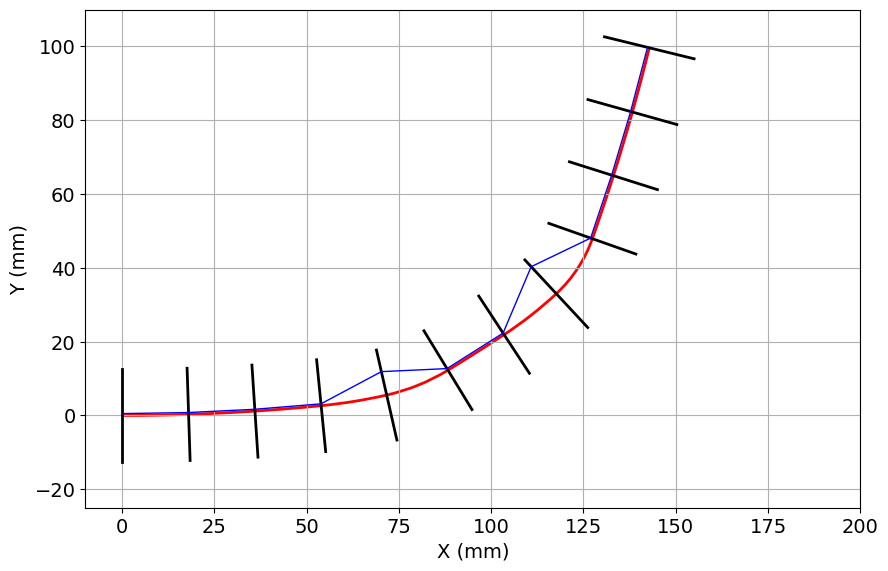

In [86]:
from tqdm import tqdm
import numpy as np
import random

def calculate_distance(arr1, arr2):
    # Use np.linalg.norm to calculate the L2 distance between two arrays
    return np.linalg.norm(np.array(arr1) - np.array(arr2))

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}


# if __name__ == "__main__":

# The tests for paper
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

angles = [0,0,0,10,15,0,10,30,0,0,0] 
# angles = [0,0,50,0,0,30,0,0,40,0,0] 
radians = [np.radians(angle) for angle in angles]


optimal_threading = []
optimal_length = 0
optimal_radians = []
min_distance = 2
max_iteration = 30
tolerance = 0.1


threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
print(len(threadings))
print("shuffle it")
# random.shuffle(threadings) 

i = 0
# Add tqdm for progress tracking in the loop
for threading in tqdm(threadings[0:max_iteration], desc="Processing Threadings"):
    i = i + 1
    cur_threading = threading[0]
    cur_length = threading[1]
    
    optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
    cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
    cur_dis = calculate_distance(cur_radians, radians)
    
    if cur_dis < min_distance:
        min_distance = cur_dis
        optimal_threading = cur_threading
        optimal_length = cur_length
        optimal_radians = cur_radians
    if i > max_iteration or min_distance < tolerance:
        break

# Calculate the geometry
print("original angles: ",angles)
print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
print("optimal threading:",optimal_threading)
print("min_distance: ",min_distance)
print("optimal string length is: ",optimal_length)
geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)

# Plot the geometry
plot_geometry(geometry,"image3.png")



In [ ]:
from tqdm import tqdm
import numpy as np
import random

def calculate_distance(arr1, arr2):
    # Use np.linalg.norm to calculate the L2 distance between two arrays
    return np.linalg.norm(np.array(arr1) - np.array(arr2))

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}


# if __name__ == "__main__":

# The tests for paper
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

# angles = [0,0,0,10,25,0,10,30,0,0,0] 
angles = [0,0,0,0,0,90,0,0,0,0,0] 
radians = [np.radians(angle) for angle in angles]


optimal_threading = []
optimal_length = 0
optimal_radians = []
min_distance = 2
max_iteration = 30
tolerance = 0.1


threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
print(len(threadings))
print("shuffle it")
# random.shuffle(threadings) 

i = 0
# Add tqdm for progress tracking in the loop
for threading in tqdm(threadings[0:max_iteration], desc="Processing Threadings"):
    i = i + 1
    cur_threading = threading[0]
    cur_length = threading[1]
    
    optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
    cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
    cur_dis = calculate_distance(cur_radians, radians)
    
    if cur_dis < min_distance:
        min_distance = cur_dis
        optimal_threading = cur_threading
        optimal_length = cur_length
        optimal_radians = cur_radians
    if i > max_iteration or min_distance < tolerance:
        break

# Calculate the geometry
print("original angles: ",angles)
print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
print("optimal threading:",optimal_threading)
print("min_distance: ",min_distance)
print("optimal string length is: ",optimal_length)
geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)

# Plot the geometry
plot_geometry(geometry,"image6.png")



In [ ]:
from tqdm import tqdm
import numpy as np
import random

def calculate_distance(arr1, arr2):
    # Use np.linalg.norm to calculate the L2 distance between two arrays
    return np.linalg.norm(np.array(arr1) - np.array(arr2))

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}


# if __name__ == "__main__":

# The tests for paper
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

# angles = [0,0,0,10,25,0,10,30,0,0,0] 
angles = [0,0,0,0,0,45,45,0,0,0,0] 
radians = [np.radians(angle) for angle in angles]


optimal_threading = []
optimal_length = 0
optimal_radians = []
min_distance = 2
max_iteration = 30
tolerance = 0.1


threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
print(len(threadings))
print("shuffle it")
# random.shuffle(threadings) 

i = 0
# Add tqdm for progress tracking in the loop
for threading in tqdm(threadings[0:max_iteration], desc="Processing Threadings"):
    i = i + 1
    cur_threading = threading[0]
    cur_length = threading[1]
    
    optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
    cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
    cur_dis = calculate_distance(cur_radians, radians)
    
    if cur_dis < min_distance:
        min_distance = cur_dis
        optimal_threading = cur_threading
        optimal_length = cur_length
        optimal_radians = cur_radians
    if i > max_iteration or min_distance < tolerance:
        break

# Calculate the geometry
print("original angles: ",angles)
print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
print("optimal threading:",optimal_threading)
print("min_distance: ",min_distance)
print("optimal string length is: ",optimal_length)
geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)

# Plot the geometry
plot_geometry(geometry,"image5.png")



The current position: x1 = 0 y1 = 0 theta1 = -1.5707963267948966
New position after arc_length: 18.0 0.0 -1.5707963267948966
The current position: x1 = 18.0 y1 = 0.0 theta1 = -1.5707963267948966
New position after arc_length: 36.0 0.0 -1.5707963267948966
The current position: x1 = 36.0 y1 = 0.0 theta1 = -1.5707963267948966
New position after arc_length: 54.0 0.0 -1.5707963267948966
The current position: x1 = 54.0 y1 = 0.0 theta1 = -1.5707963267948966
New position after arc_length: 71.90875386081538 -1.5668129406974742 -1.7453292519943295
The current position: x1 = 71.90875386081538 y1 = -1.5668129406974742 theta1 = -1.7453292519943295
New position after arc_length: 88.0365795355483 -9.087341562214238 -2.2689280275926285
The current position: x1 = 88.0365795355483 y1 = -9.087341562214238 theta1 = -2.2689280275926285
New position after arc_length: 101.8253795116899 -20.65751853657195 -2.2689280275926285
The current position: x1 = 101.8253795116899 y1 = -20.65751853657195 theta1 = -2.2689

Processing Threadings: 100%|████████████████████| 15/15 [02:52<00:00, 11.51s/it]


original angles:  [0, 0, 0, -10, -30, 0, 10, 30, 0, 0, 0]
optimal angles:  [  3.    3.    3.   -7.2 -28.1   3.   11.6  29.9   3.    3.    3. ]
optimal threading: [-0.5, -0.5, -0.5, -0.5, 6.5, -0.5, -0.5, -6.5, -0.5, -0.5, -0.5, -0.5]
min_distance:  0.15320873716890313
optimal string length is:  196.48415309446096
[0.052465488083423606, 0.05246552444607278, 0.052465546274094846, -0.12617804881620054, -0.49124531177866027, 0.052465512862768085, 0.20308638686837632, 0.5215337767001612, 0.052465499629082216, 0.05246551546501595, 0.05246552024548803]


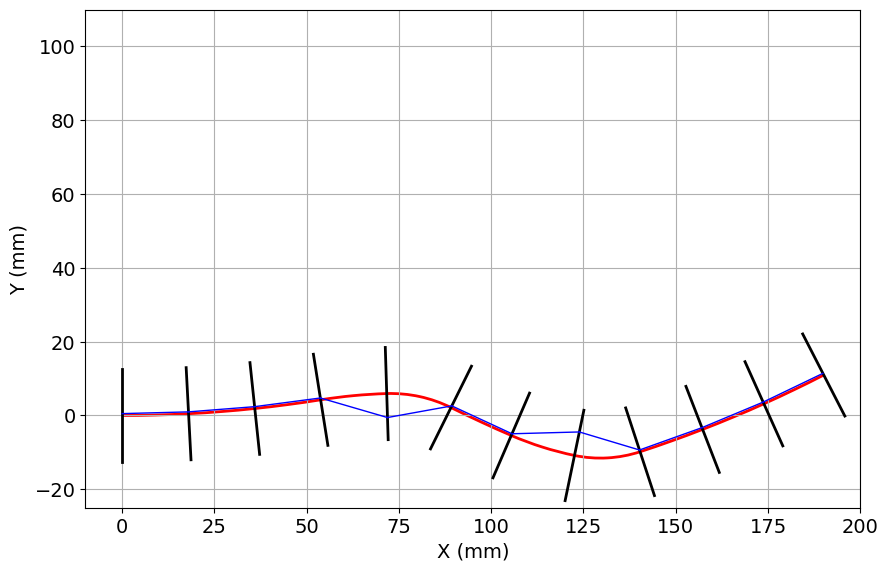

In [87]:
from tqdm import tqdm
import numpy as np
import random

def calculate_distance(arr1, arr2):
    # Use np.linalg.norm to calculate the L2 distance between two arrays
    return np.linalg.norm(np.array(arr1) - np.array(arr2))

wiring_mapping = {
    "L0": -0.5,
    "L1": -3,
    "L2": -6.5,
    "L3": -10,
    "R0": 0.5,
    "R1": 3,
    "R2": 6.5,
    "R3": 10
}


# if __name__ == "__main__":

# The tests for paper
arc_length = 18  # arc的长度
rod_length = 25  # rod的长度
x1, y1 = 0, 0  # 起始点
theta1 = -np.pi/2  # 起始角度

angles = [0,0,0,-10,-30,0,10,30,0,0,0] 
# angles = [0,0,50,0,0,30,0,0,40,0,0] 
radians = [np.radians(angle) for angle in angles]


optimal_threading = []
optimal_length = 0
optimal_radians = []
min_distance = 2
max_iteration = 30
tolerance = 0.1


threadings = find_threadings(x1, y1, theta1, arc_length, radians, rod_length)
print(len(threadings))
print("shuffle it")
# random.shuffle(threadings) 

i = 0
# Add tqdm for progress tracking in the loop
for threading in tqdm(threadings[0:max_iteration], desc="Processing Threadings"):
    i = i + 1
    cur_threading = threading[0]
    cur_length = threading[1]
    
    optimal_string_length = optimize_radians_get_string_length(cur_threading, cur_length, x1, y1, theta1, arc_length)
    cur_radians = calculate_radians_based_on_string_length(x1, y1, theta1, arc_length, optimal_string_length, cur_threading)
    cur_dis = calculate_distance(cur_radians, radians)
    
    if cur_dis < min_distance:
        min_distance = cur_dis
        optimal_threading = cur_threading
        optimal_length = cur_length
        optimal_radians = cur_radians
    if i > max_iteration or min_distance < tolerance:
        break

# Calculate the geometry
print("original angles: ",angles)
print("optimal angles: ",np.round(np.degrees(optimal_radians), 1))
print("optimal threading:",optimal_threading)
print("min_distance: ",min_distance)
print("optimal string length is: ",optimal_length)
geometry = calculate_geometry(rod_length, x1, y1, theta1, arc_length, optimal_radians, optimal_threading)

# Plot the geometry
plot_geometry(geometry,"image4.png")



In [88]:
from PIL import Image

def trim(image_path, output_path, left, top, right, bottom):
    # Open the image file
    img = Image.open(image_path)
    
    # Get the original dimensions
    width, height = img.size
    
    # Calculate the box to crop: (left, top, right, bottom)
    crop_box = (left, top, width - right, height - bottom)
    
    # Ensure the crop_box is within image bounds
    if crop_box[0] < 0 or crop_box[1] < 0 or crop_box[2] > width or crop_box[3] > height:
        print("Invalid crop dimensions.")
        return
    
    # Crop the image
    img_cropped = img.crop(crop_box)
    
    # Save the trimmed image
    img_cropped.save(output_path)
    print(f"Trimmed image saved as {output_path}")

# Example usage: Trim 10 pixels from each side
trim("image1.png", "trimmed_image1.png", left=50, top=250, right=60, bottom=160)
trim("image2.png", "trimmed_image2.png", left=50, top=250, right=60, bottom=160)
trim("image3.png", "trimmed_image3.png", left=50, top=250, right=60, bottom=160)
trim("image4.png", "trimmed_image4.png", left=50, top=250, right=60, bottom=160)
trim("image5.png", "trimmed_image5.png", left=50, top=0, right=60, bottom=0)
trim("image6.png", "trimmed_image6.png", left=50, top=0, right=60, bottom=0)


Trimmed image saved as trimmed_image1.png
Trimmed image saved as trimmed_image2.png
Trimmed image saved as trimmed_image3.png
Trimmed image saved as trimmed_image4.png
Trimmed image saved as trimmed_image5.png
Trimmed image saved as trimmed_image6.png
